In [2]:
import pandas as pd
import glob
import os

# =========================================================
# 0. 기본 설정
# =========================================================

DATA_DIR = "../food"
CHUNKSIZE = 200_000

USECOLS = [
    "sex",
    "age",
    "hour",
    "day",
    "card_tpbuz_nm_2",
    "amt",
    "cnt"
]

files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
print(f"총 파일 수: {len(files)}")

# =========================================================
# 1. 누적용 딕셔너리 초기화
# =========================================================

sex_stats = {}
age_stats = {}
category_stats = {}
hour_stats = {}
day_stats = {}

total_rows = 0

# =========================================================
# 2. 파일 + chunk 순회
# =========================================================

for file in files:
    print(f"Processing: {os.path.basename(file)}")

    for chunk in pd.read_csv(
        file,
        usecols=USECOLS,
        chunksize=CHUNKSIZE
    ):
        total_rows += len(chunk)

        def accumulate(group_col, target_dict):
            grouped = chunk.groupby(group_col)[["amt", "cnt"]].sum()
            for idx, row in grouped.iterrows():
                if idx not in target_dict:
                    target_dict[idx] = {"amt": 0, "cnt": 0}
                target_dict[idx]["amt"] += row["amt"]
                target_dict[idx]["cnt"] += row["cnt"]

        accumulate("sex", sex_stats)
        accumulate("age", age_stats)
        accumulate("card_tpbuz_nm_2", category_stats)
        accumulate("hour", hour_stats)
        accumulate("day", day_stats)

# =========================================================
# 3. DataFrame 변환 + 비율 계산
# =========================================================

def to_df(stats_dict):
    df = pd.DataFrame.from_dict(stats_dict, orient="index")
    df["amt_ratio"] = df["amt"] / df["amt"].sum()
    df["cnt_ratio"] = df["cnt"] / df["cnt"].sum()
    return df

df_sex = to_df(sex_stats)
df_age = to_df(age_stats)
df_category = to_df(category_stats)
df_hour = to_df(hour_stats)
df_day = to_df(day_stats)

print("편향성 집계 완료")


총 파일 수: 47
Processing: 202201.csv
Processing: 202202.csv
Processing: 202203.csv
Processing: 202204.csv
Processing: 202205.csv
Processing: 202206.csv
Processing: 202207.csv
Processing: 202208.csv
Processing: 202209.csv
Processing: 202210.csv
Processing: 202211.csv
Processing: 202212.csv
Processing: 202301.csv
Processing: 202302.csv
Processing: 202303.csv
Processing: 202304.csv
Processing: 202305.csv
Processing: 202306.csv
Processing: 202307.csv
Processing: 202308.csv
Processing: 202309.csv
Processing: 202310.csv
Processing: 202311.csv
Processing: 202312.csv
Processing: 202401.csv
Processing: 202402.csv
Processing: 202403.csv
Processing: 202404.csv
Processing: 202405.csv
Processing: 202406.csv
Processing: 202407.csv
Processing: 202408.csv
Processing: 202409.csv
Processing: 202410.csv
Processing: 202411.csv
Processing: 202412.csv
Processing: 202501.csv
Processing: 202502.csv
Processing: 202503.csv
Processing: 202504.csv
Processing: 202505.csv
Processing: 202506.csv
Processing: 202507.csv


In [3]:
SAVE_DIR = "../eda_bias_result"
os.makedirs(SAVE_DIR, exist_ok=True)

df_sex.to_csv(f"{SAVE_DIR}/bias_sex_amt_cnt.csv", encoding="utf-8-sig")
df_age.to_csv(f"{SAVE_DIR}/bias_age_amt_cnt.csv", encoding="utf-8-sig")
df_category.to_csv(f"{SAVE_DIR}/bias_category_amt_cnt.csv", encoding="utf-8-sig")
df_hour.to_csv(f"{SAVE_DIR}/bias_hour_amt_cnt.csv", encoding="utf-8-sig")
df_day.to_csv(f"{SAVE_DIR}/bias_day_amt_cnt.csv", encoding="utf-8-sig")

print("CSV 저장 완료")

CSV 저장 완료


In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

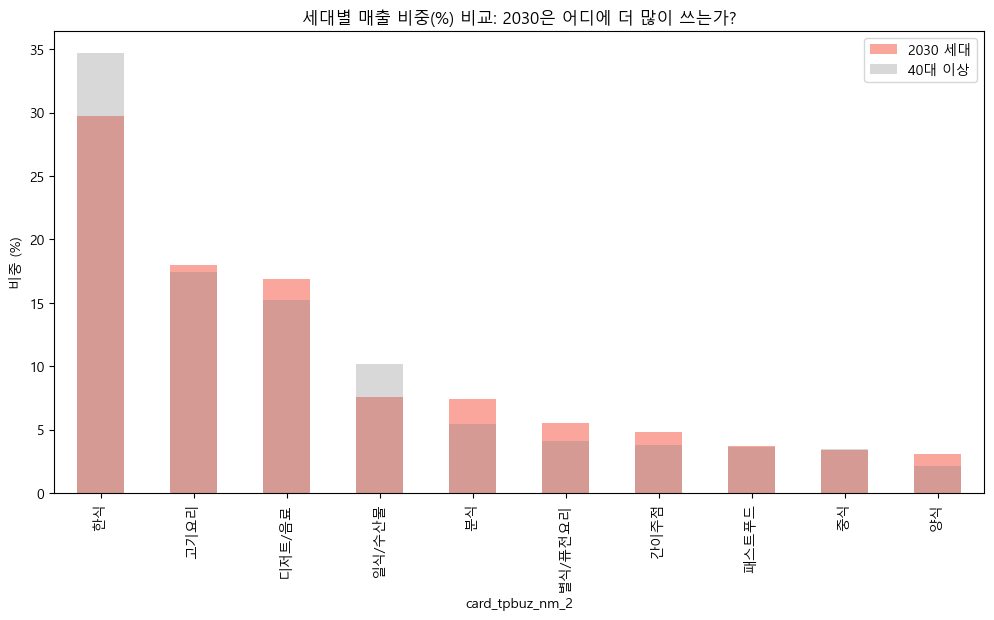

ValueError: Could not interpret value `date` for `x`. An entry with this name does not appear in `data`.

<Figure size 1400x700 with 0 Axes>

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 및 전처리
df_age = pd.read_csv('../output/age_category_summary_202201_202511.csv')

# 컬럼명 정리 (파일 내 month, age_group, card_tpbuz_nm_2, amt 기준)
# month 컬럼을 datetime으로 변환하여 시간 분석 준비
df_age['month'] = pd.to_datetime(df_age['month'].astype(str), format='%Y%m')

# 2. [분석 1] 2030 vs 40대 이상 업종 선호도 비교
# 타깃 세대(2030)와 비교 세대(40대 이상) 정의
df_2030 = df_age[df_age['age_group'].isin(['20대', '30대'])]
df_40plus = df_age[df_age['age_group'].isin(['40대', '50대', '60대+'])]

# 세대별 전체 매출 대비 업종별 비중 계산 함수
def get_share(df):
    total = df.groupby('card_tpbuz_nm_2')['amt'].sum()
    return (total / total.sum() * 100).sort_values(ascending=False)

share_2030 = get_share(df_2030)
share_40plus = get_share(df_40plus)

# 시각화: 2030의 선호도 랭킹

plt.figure(figsize=(12, 6))
share_2030.plot(kind='bar', color='salmon', alpha=0.7, label='2030 세대')
share_40plus.plot(kind='bar', color='gray', alpha=0.3, label='40대 이상')
plt.title('세대별 매출 비중(%) 비교: 2030은 어디에 더 많이 쓰는가?')
plt.ylabel('비중 (%)')
plt.legend()
plt.show()

# 3. [분석 2] 2030의 시간 흐름에 따른 업종별 매출 트렌드
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_2030, x='date', y='amt', hue='card_tpbuz_nm_2')
plt.title('2030 세대의 연도별 카테고리 매출 변화 (2022-2025)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 4. [분석 3] 2030 계절성 분석 (월별 히트맵)
df_2030['only_month'] = df_2030['date'].dt.month
seasonal_2030 = df_2030.pivot_table(index='only_month', columns='card_tpbuz_nm_2', values='amt', aggfunc='mean')

# 정규화 (Max-Min) 하여 월별 집중도 확인
seasonal_norm = (seasonal_2030 - seasonal_2030.min()) / (seasonal_2030.max() - seasonal_2030.min())

plt.figure(figsize=(12, 8))
sns.heatmap(seasonal_norm, cmap='RdPu', annot=False)
plt.title('2030 세대 업종별 시즌 집중도 (1에 가까울수록 해당 월에 소비 집중)')
plt.show()

✅ 데이터 준비 완료. 컬럼 확인: ['month', 'age_group', 'card_tpbuz_nm_2', 'amt', 'date', 'year', 'only_month']

📈 [분석 1] 2030 세대 카테고리별 매출 추이 분석 중...


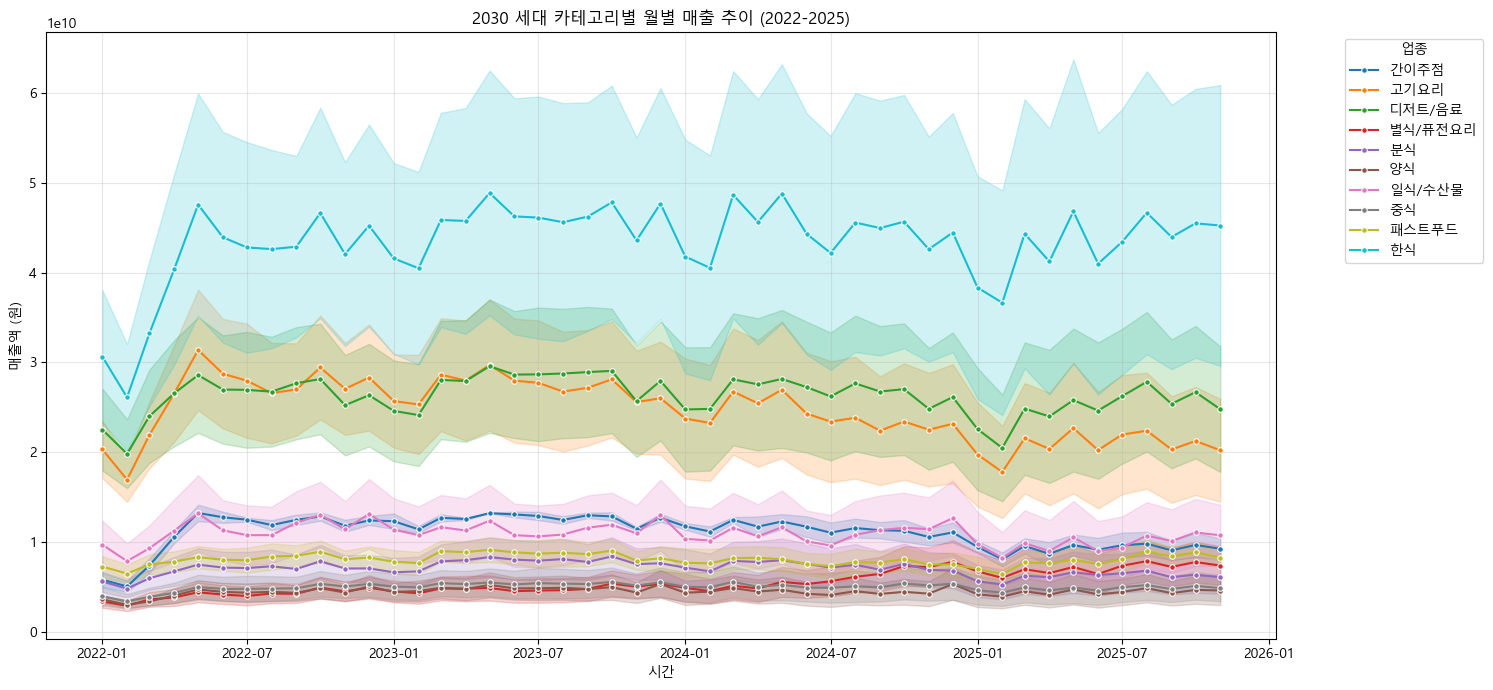


❄️☀️ [분석 2] 월별 소비 집중도 분석 중...


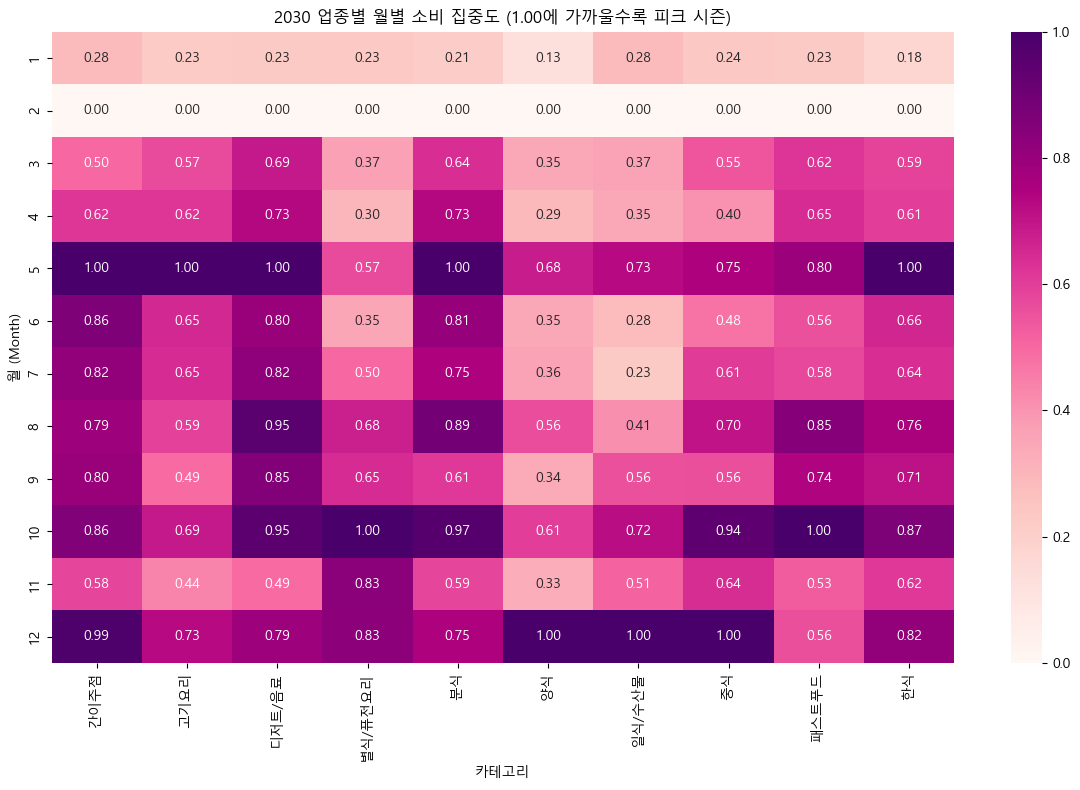


🆚 [분석 3] 20대 vs 30대 소비 비중 비교 분석 중...


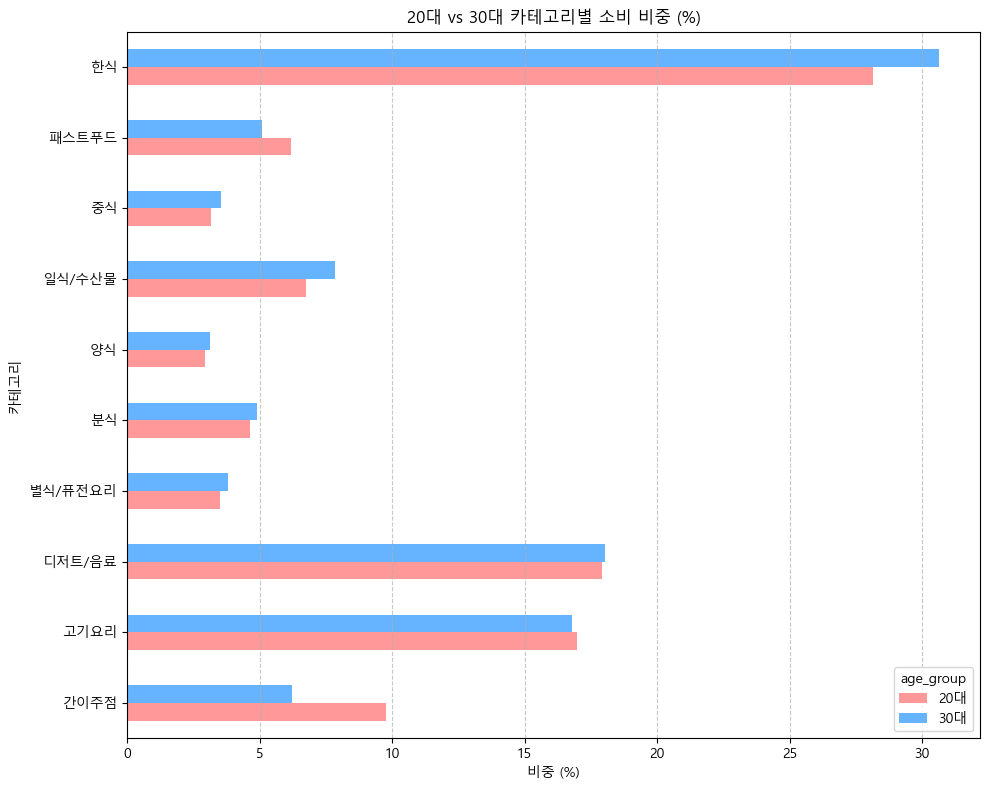

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# 1. 한글 폰트 설정 (에러 방지)
if platform.system() == 'Darwin': plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 2. 데이터 로드 및 전처리 (순서 보장)
df_age = pd.read_csv('../output/age_category_summary_202201_202511.csv')

# [중요] 컬럼 생성 후 필터링을 해야 'date'가 사라지지 않습니다.
df_age['date'] = pd.to_datetime(df_age['month'].astype(str), format='%Y%m')
df_age['year'] = df_age['date'].dt.year
df_age['only_month'] = df_age['date'].dt.month

# 2030 세대만 따로 추출 (복사본 생성으로 에러 방지)
df_2030 = df_age[df_age['age_group'].isin(['20대', '30대'])].copy()

print("✅ 데이터 준비 완료. 컬럼 확인:", df_2030.columns.tolist())

# ==========================================
# [시나리오 1] 2030 성장/사양 업종 트렌드 분석
# ==========================================
def analyze_growth_trend(df):
    print("\n📈 [분석 1] 2030 세대 카테고리별 매출 추이 분석 중...")
    
    plt.figure(figsize=(15, 7))
    # 'date' 컬럼을 x축으로 사용하여 시계열 그래프 생성
    sns.lineplot(data=df, x='date', y='amt', hue='card_tpbuz_nm_2', marker='o', markersize=4)
    
    plt.title('2030 세대 카테고리별 월별 매출 추이 (2022-2025)')
    plt.ylabel('매출액 (원)')
    plt.xlabel('시간')
    plt.legend(title='업종', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ==========================================
# [시나리오 2] 2030 계절성(Seasonality) 히트맵
# ==========================================
def analyze_seasonality(df):
    print("\n❄️☀️ [분석 2] 월별 소비 집중도 분석 중...")
    
    # 월별/업종별 평균 매출 계산
    seasonal_pivot = df.pivot_table(index='only_month', columns='card_tpbuz_nm_2', values='amt', aggfunc='mean')
    
    # 업종별로 스케일이 다르므로, 월별 패턴만 보기 위해 정규화(0~1)
    seasonal_norm = (seasonal_pivot - seasonal_pivot.min()) / (seasonal_pivot.max() - seasonal_pivot.min())
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(seasonal_norm, cmap='RdPu', annot=True, fmt='.2f')
    plt.title('2030 업종별 월별 소비 집중도 (1.00에 가까울수록 피크 시즌)')
    plt.ylabel('월 (Month)')
    plt.xlabel('카테고리')
    plt.tight_layout()
    plt.show()

# ==========================================
# [시나리오 3] 20대 vs 30대 소비 점유율 비교
# ==========================================
def compare_20s_30s(df):
    print("\n🆚 [분석 3] 20대 vs 30대 소비 비중 비교 분석 중...")
    
    # 전체 기간 업종별 비중 계산
    pivot = df.pivot_table(index='card_tpbuz_nm_2', columns='age_group', values='amt', aggfunc='sum')
    
    # 각 연령대별 전체 매출 대비 비중(%)으로 변환
    pivot_pct = pivot.div(pivot.sum(axis=0), axis=1) * 100
    
    pivot_pct.plot(kind='barh', figsize=(10, 8), color=['#ff9999','#66b3ff'])
    plt.title('20대 vs 30대 카테고리별 소비 비중 (%)')
    plt.xlabel('비중 (%)')
    plt.ylabel('카테고리')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 실행부
if __name__ == "__main__":
    analyze_growth_trend(df_2030)  # 트렌드 분석
    analyze_seasonality(df_2030)   # 계절성 분석
    compare_20s_30s(df_2030)       # 20대 vs 30대 비교


❄️☀️ [분석 2 보정] 일평균 매출 기반 시즌 집중도 분석 중...


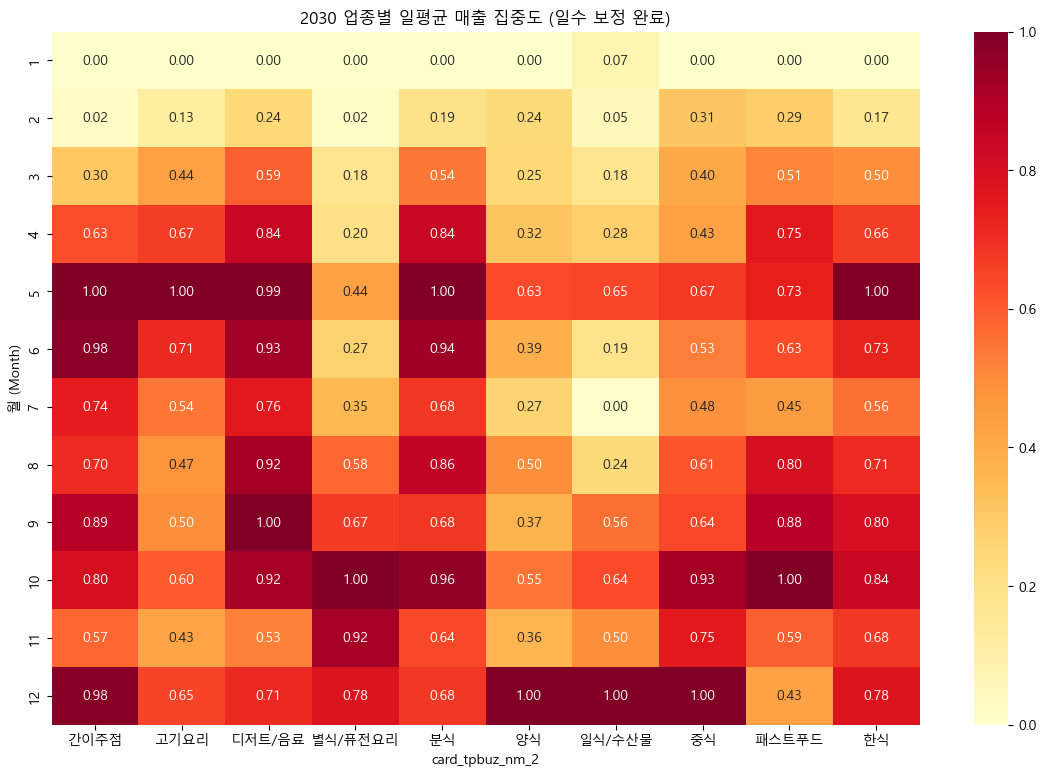

In [2]:
def analyze_seasonality_fixed(df):
    print("\n❄️☀️ [분석 2 보정] 일평균 매출 기반 시즌 집중도 분석 중...")
    
    # 1. 각 달의 일수(Days) 매핑
    month_days = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    
    # 2. 월별 평균 매출 계산
    seasonal_pivot = df.pivot_table(index='only_month', columns='card_tpbuz_nm_2', values='amt', aggfunc='mean')
    
    # 3. [핵심] 일평균 매출로 변환 (2월의 불리함 제거)
    for m in seasonal_pivot.index:
        seasonal_pivot.loc[m] = seasonal_pivot.loc[m] / month_days[m]
    
    # 4. 정규화 (다시 수행)
    seasonal_norm = (seasonal_pivot - seasonal_pivot.min()) / (seasonal_pivot.max() - seasonal_pivot.min())
    
    plt.figure(figsize=(14, 9))
    sns.heatmap(seasonal_norm, cmap='YlOrRd', annot=True, fmt='.2f')
    plt.title('2030 업종별 일평균 매출 집중도 (일수 보정 완료)')
    plt.ylabel('월 (Month)')
    plt.show()

# 다시 실행
analyze_seasonality_fixed(df_2030)


📊 [분석 2 수정] 월별 업종 점유율(Share) 분석 중...


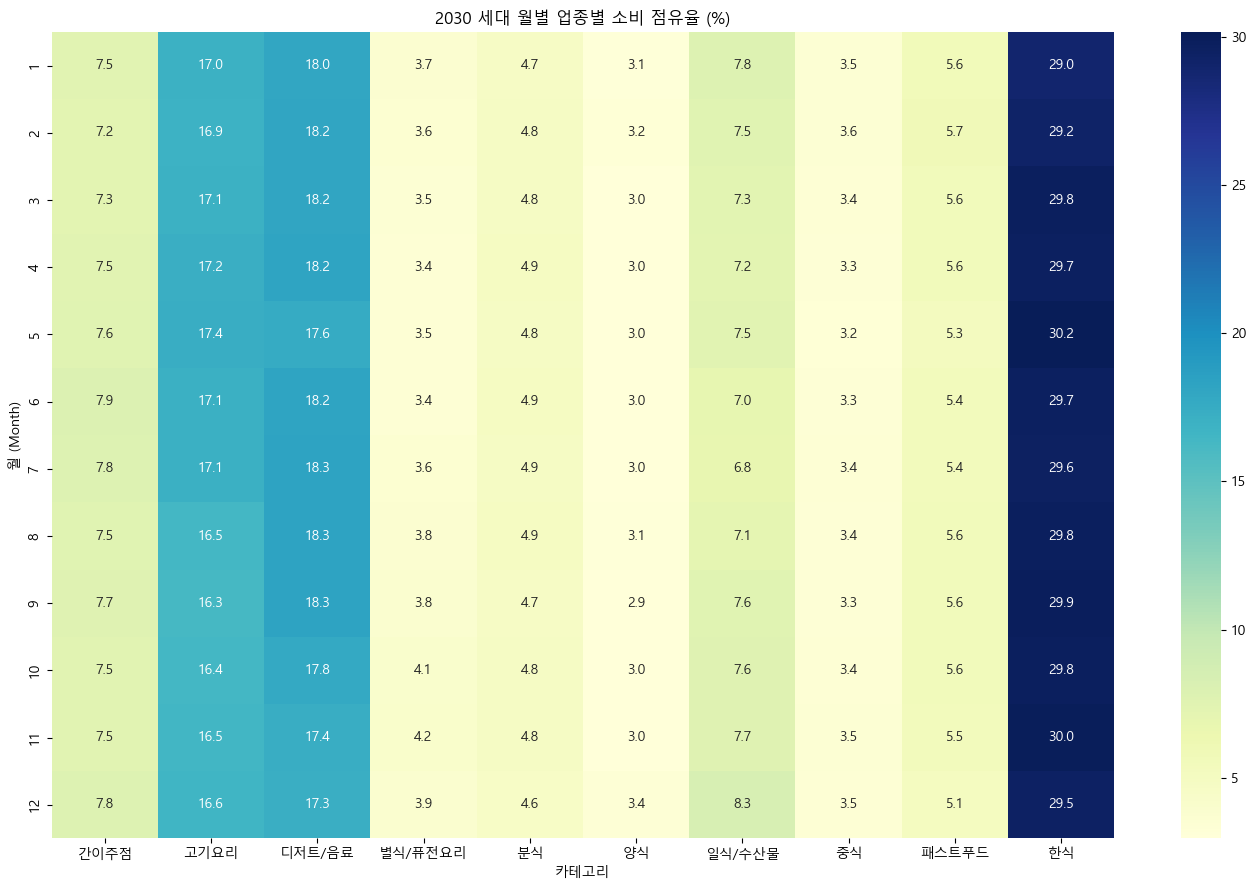

In [3]:
def analyze_seasonality_share(df):
    print("\n📊 [분석 2 수정] 월별 업종 점유율(Share) 분석 중...")
    
    # 1. 월별/업종별 매출 합계 계산
    seasonal_pivot = df.pivot_table(index='only_month', columns='card_tpbuz_nm_2', values='amt', aggfunc='mean')
    
    # 2. [핵심] 각 '월' 내에서 업종별 비중(%) 계산 
    # (예: 1월 전체 소비 중 한식이 차지하는 비중)
    seasonal_share = seasonal_pivot.div(seasonal_pivot.sum(axis=1), axis=0) * 100
    
    plt.figure(figsize=(14, 9))
    # 비중 데이터이므로 정규화 없이 실제 값(%)을 히트맵으로 표현
    sns.heatmap(seasonal_share, cmap='YlGnBu', annot=True, fmt='.1f')
    
    plt.title('2030 세대 월별 업종별 소비 점유율 (%)')
    plt.ylabel('월 (Month)')
    plt.xlabel('카테고리')
    plt.tight_layout()
    plt.show()

# 실행
analyze_seasonality_share(df_2030)

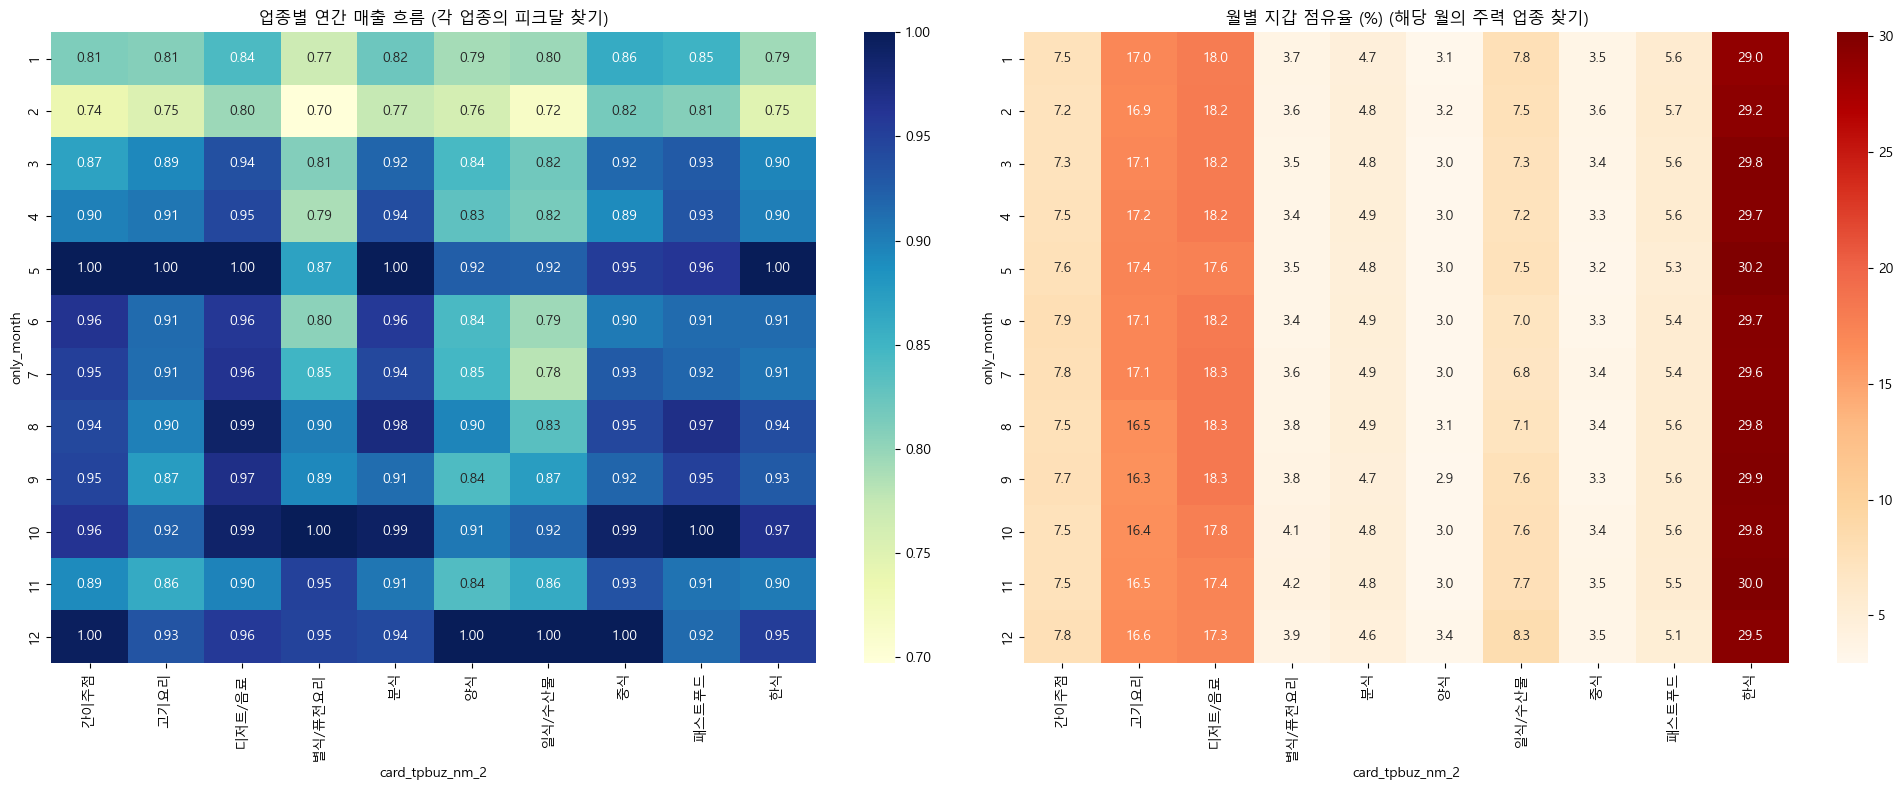

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 2030 필터링
df = pd.read_csv('../output/age_category_summary_202201_202511.csv')
df_2030 = df[df['age_group'].isin(['20대', '30대'])].copy()
df_2030['only_month'] = pd.to_datetime(df_2030['month'].astype(str), format='%Y%m').dt.month

# [보정된 분석] 
# 각 달의 '절대 금액'이 아닌 '평균적인 흐름'을 보기 위해 월별/업종별 평균을 먼저 냅니다.
pivot_table = df_2030.pivot_table(index='only_month', columns='card_tpbuz_nm_2', values='amt', aggfunc='mean')

# ==========================================
# 관점 A. 업종 내 변화 (히트맵에 적합)
# "이 업종은 몇 월에 대박이 나는가?"
# ==========================================
# 업종별로 최대치를 1로 만들어서 비교 (Max Scaling)
seasonality_norm = pivot_table / pivot_table.max()

# ==========================================
# 관점 B. 월 내 비중 (점유율에 적합)
# "이번 달 2030 지갑의 주인은 누구인가?"
# ==========================================
share_table = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# 시각화 비교
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# 히트맵 (시즌성)
sns.heatmap(seasonality_norm, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax[0])
ax[0].set_title('업종별 연간 매출 흐름 (각 업종의 피크달 찾기)')

# 히트맵 (점유율)
sns.heatmap(share_table, annot=True, fmt='.1f', cmap='OrRd', ax=ax[1])
ax[1].set_title('월별 지갑 점유율 (%) (해당 월의 주력 업종 찾기)')

plt.tight_layout()
plt.show()

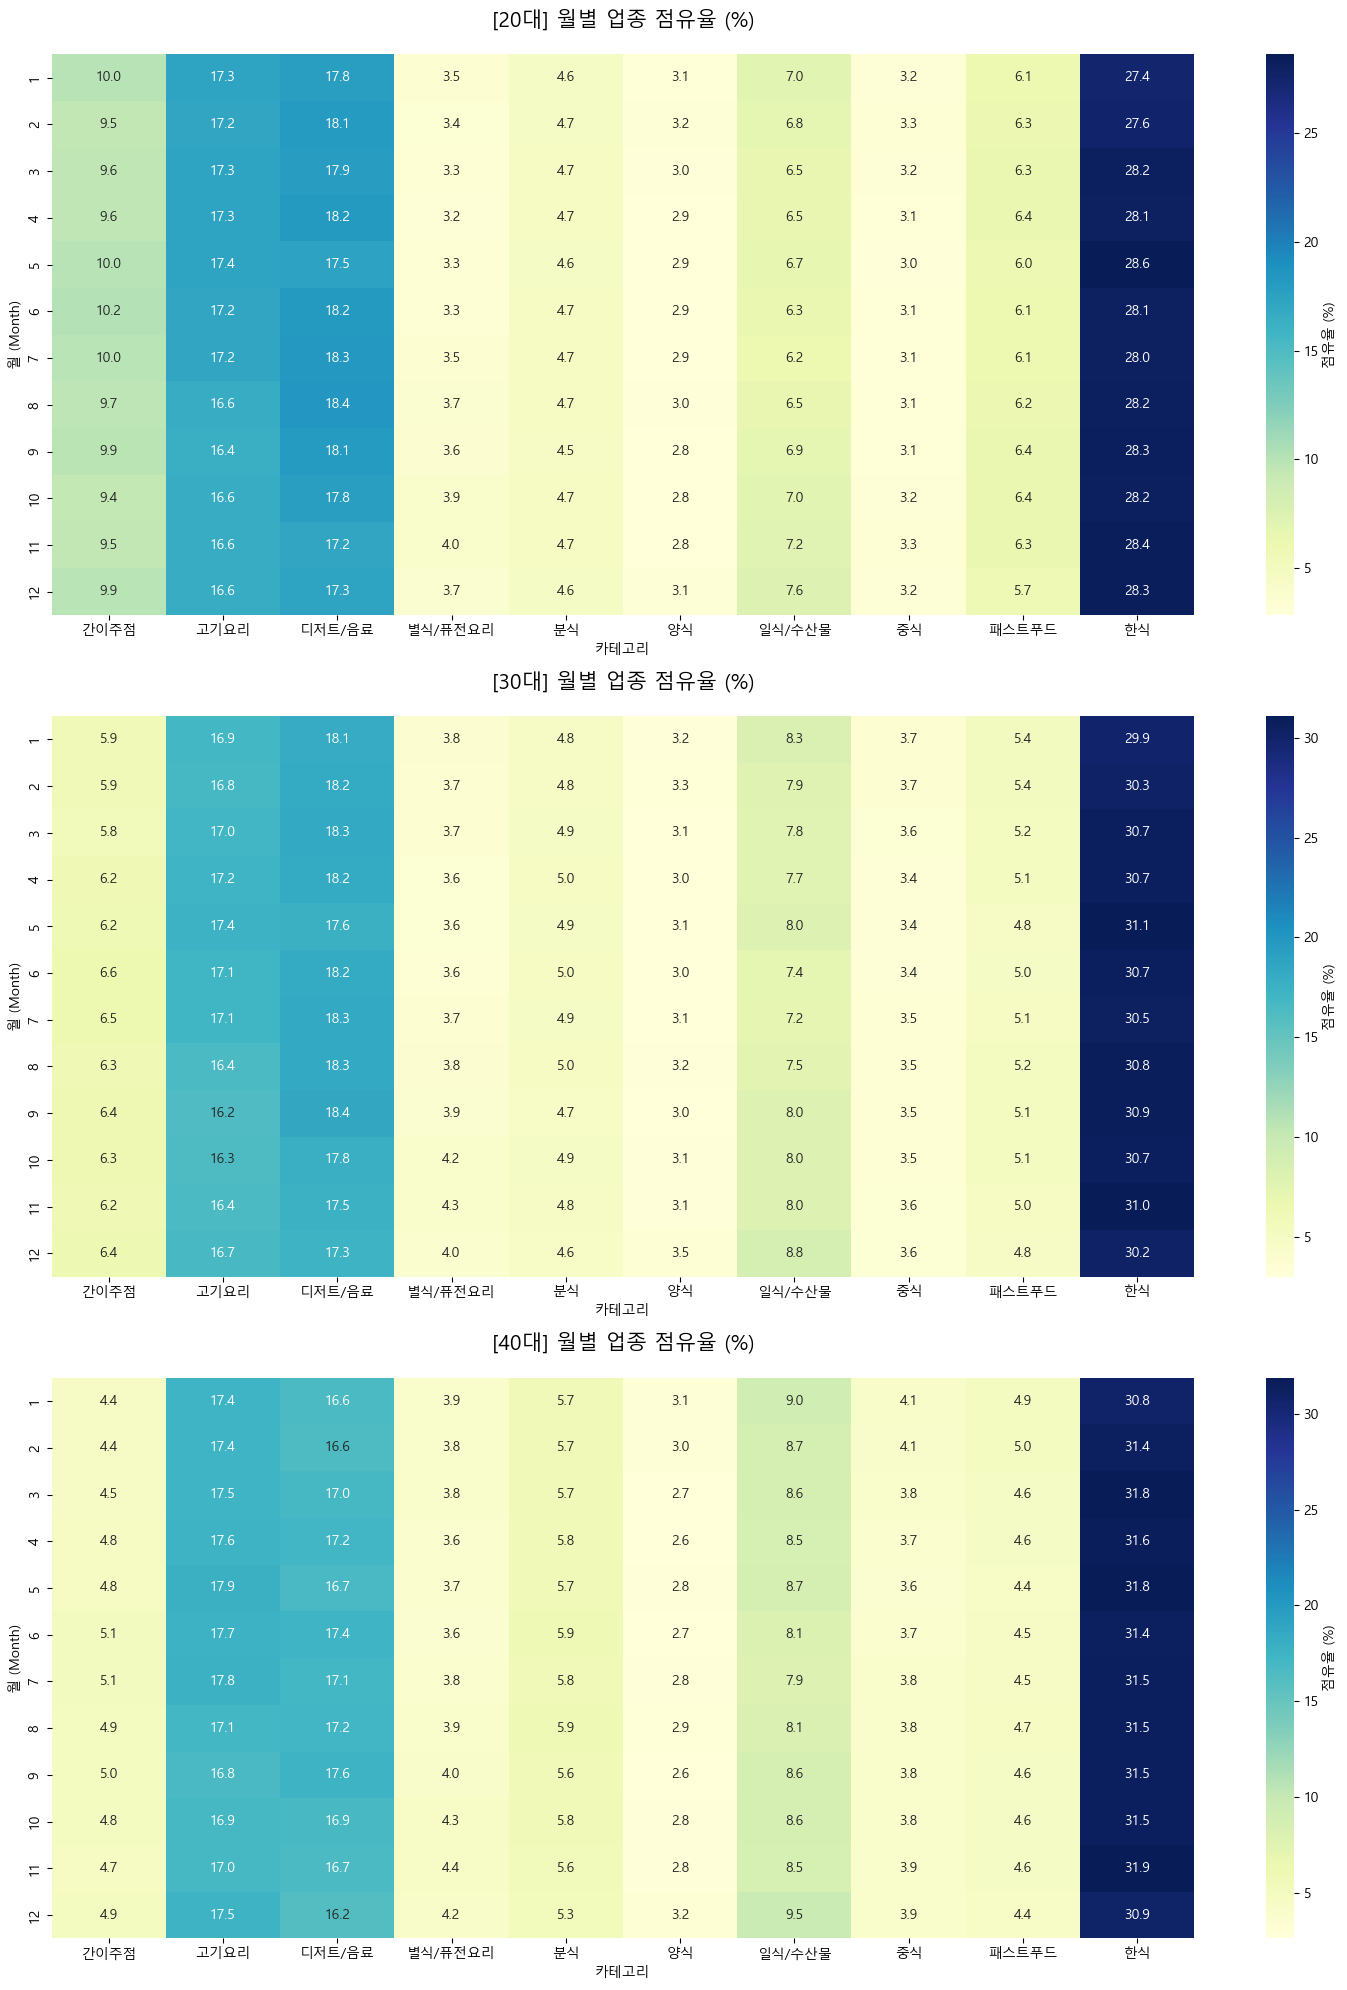

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 전처리
df_age = pd.read_csv('../output/age_category_summary_202201_202511.csv')
df_age['only_month'] = pd.to_datetime(df_age['month'].astype(str), format='%Y%m').dt.month

# 분석 대상 세대 설정
target_ages = ['20대', '30대', '40대']
df_filtered = df_age[df_age['age_group'].isin(target_ages)].copy()

# 2. 시각화 설정 (3개의 세대를 나란히 비교)
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

for i, age in enumerate(target_ages):
    # 세대별 데이터 분리
    df_sub = df_filtered[df_filtered['age_group'] == age]
    
    # 월별/업종별 평균 매출 피벗
    pivot = df_sub.pivot_table(index='only_month', columns='card_tpbuz_nm_2', values='amt', aggfunc='mean')
    
    # 점유율(%)로 변환 (해당 월 내 비중)
    share_table = pivot.div(pivot.sum(axis=1), axis=0) * 100
    
    # 히트맵 그리기
    sns.heatmap(share_table, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[i], cbar_kws={'label': '점유율 (%)'})
    axes[i].set_title(f'[{age}] 월별 업종 점유율 (%)', fontsize=15, pad=20)
    axes[i].set_ylabel('월 (Month)')
    axes[i].set_xlabel('카테고리')

plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
import glob
import os

# =================================================
# 1. 설정
# =================================================
DATA_PATH = "../food/*.csv"
file_list = sorted(glob.glob(DATA_PATH))

chunk_size = 200_000
monthly_data = []

age_group_map = {
    2: "20대",
    3: "30대",
    4: "40대",
    5: "50대",
    6: "60대 이상"
}

use_cols = [
    "card_tpbuz_nm_2",
    "amt",
    "cnt",
    "age",
    "sex"
]

# =================================================
# 2. 파일 단위 처리
# =================================================
for file in file_list:
    year_month = os.path.basename(file).replace(".csv", "")

    # 파일 단위 누적용 dict
    agg_dict = {}

    for chunk in pd.read_csv(
        file,
        usecols=use_cols,
        chunksize=chunk_size
    ):
        # ---------------------------------
        # (1) 10대 이하 제거
        # ---------------------------------
        chunk = chunk[chunk["age"] >= 2]

        # ---------------------------------
        # (2) 연령대 매핑
        # ---------------------------------
        chunk["age_group"] = chunk["age"].map(age_group_map)
        chunk = chunk.dropna(subset=["age_group"])

        # ---------------------------------
        # (4) chunk 단위 집계
        # ---------------------------------
        grouped = (
            chunk
            .groupby(
                ["age_group", "sex", "card_tpbuz_nm_2"],
                observed=True
            )
            .agg(
                amt=("amt", "sum"),
                cnt=("cnt", "sum")
            )
        )

        # ---------------------------------
        # (5) 파일 단위 누적
        # ---------------------------------
        for idx, row in grouped.iterrows():
            if idx not in agg_dict:
                agg_dict[idx] = {"amt": 0, "cnt": 0}

            agg_dict[idx]["amt"] += row["amt"]
            agg_dict[idx]["cnt"] += row["cnt"]

    # =================================================
    # 3. 파일 하나 완료 → DataFrame 변환
    # =================================================
    if agg_dict:
        file_df = (
            pd.DataFrame.from_dict(agg_dict, orient="index")
            .reset_index()
        )

        file_df.columns = [
            "age_group",
            "sex",
            "card_tpbuz_nm_2",
            "amt",
            "cnt"
        ]

        file_df["year_month"] = year_month
        monthly_data.append(file_df)

# =================================================
# 4. 전체 병합 (딱 1번)
# =================================================
df_monthly = pd.concat(monthly_data, ignore_index=True)

# 컬럼 정렬
df_monthly = df_monthly[
    ["year_month", "age_group", "sex", "card_tpbuz_nm_2", "amt", "cnt"]
]


In [14]:
df_monthly

,year_month,age_group,sex,card_tpbuz_nm_2,amt,cnt
0,202201,20대,F,간이주점,2312645418,64578
1,202201,20대,F,고기요리,6146013489,178108
2,202201,20대,F,디저트/음료,9202185680,1031069
3,202201,20대,F,별식/퓨전요리,1023885766,50006
4,202201,20대,F,분식,1886307189,169341
...,...,...,...,...,...,...
4695,202511,60대 이상,M,양식,1386227284,34022
4696,202511,60대 이상,M,일식/수산물,12252687612,256853
4697,202511,60대 이상,M,중식,3241628008,137906
4698,202511,60대 이상,M,패스트푸드,2128267643,156497


In [15]:
df_monthly.to_csv(
    "../output/all_category_summary_202201_202511.csv",
    index=False,
    encoding="utf-8-sig"
)
